# Mental Health Chatbot

## Introduction

## SDGs

# Initial Procedure

The following procedure to train a mental health chatbot is taken from https://github.com/pandeyanuradha/Chatbot-for-mental-health/blob/main/Models/Generative_based.ipynb.

In the second part of this document, techniques to improve the quality of the procedure are analysed.

## Loading data and preliminary analysis

This code snippet sets up the environment for the mental health chatbot by installing necessary libraries from a `requirements.txt` file using `pip`.

In [ ]:
# Install dependencies

%pip install -r 'requirements.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow-macos==2.13.0 (from versions: none)
ERROR: No matching distribution found for tensorflow-macos==2.13.0


The following code snippet imports necessary libraries for building and visualizing the mental health chatbot. It imports `re` for regular expressions, `random` for generating random numbers, `pandas` for data manipulation, `numpy` for numerical operations, `plot_model` from `tensorflow.keras.utils` for visualizing the model structure, `load_model` from `keras.models` for loading pre-trained models, and `matplotlib.pyplot` for plotting graphs. Additionally, it sets a pandas option to suppress chained assignment warnings. These imports and configuration settings prepare the environment for subsequent steps in the chatbot development process.

In [ ]:
import re
import random
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)
path_to_csv = 'mentalhealth.csv'

Pandas is used to load the training data from the `mentalhealth.csv` file into a DataFrame. Only the first 20 rows are considered for now.

In [ ]:
data = pd.read_csv(path_to_csv, nrows=20)

The first 5 rows of the DataFrame are examined.

In [ ]:
data.head()

,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,"Mental illness does can affect anyone, regardl..."
2,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
3,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."
4,1619387,What should I do if I know someone who appears...,We encourage those with symptoms to talk to th...


The DataFrame has three columns:

1.   `Question_ID`: the unique ID of the row
2.   `Questions`: mental health related questions
3.   `Answers`: mental health related answers

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Question_ID  20 non-null     int64 
 1   Questions    20 non-null     object
 2   Answers      20 non-null     object
dtypes: int64(1), object(2)
memory usage: 608.0+ bytes


There are 3 columns and 97 rows in the dataset.

In [ ]:
data.shape

(20, 3)

`data.isna().sum()` helps identify the presence and count of missing values within the dataset, allowing to assess data quality and potentially handle missing values before proceeding with further analysis or model training. No values are missing in this dataset.

In [ ]:
data.isna().sum()

,0
Question_ID,0
Questions,0
Answers,0


This code block focuses on cleaning and preparing the 'Answers' column of the dataset for further use. It iterates through each answer in the dataset and applies a series of regular expression substitutions to remove or replace specific characters and patterns. Special characters that interfere with model training are removed. They don't contribute to the meaning of text when processed by algorithms and can introduce errors or confusion. Therefore, it's necessary to remove them during text analysis.



In [ ]:
# data preprocessing

for i in range(data.shape[0]):
  data.loc[i, 'Answers'] = re.sub(r'\n', ' ', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub('\(', '', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r'\)', '', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r',', ' ', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r'-', '', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r'/', '', data.loc[i, 'Answers'])

In the following section a list of question and answer pairs is created. It is used in the following steps of the procedure.

In [ ]:
pairs = []

for i in range(data.shape[0]):
  pairs.append(((data['Questions'][i]), data['Answers'][i]))

In [ ]:
pairs[0]

('What does it mean to have a mental illness?',
 "Mental illnesses are health conditions that disrupt a person's thoughts  emotions  relationships  and daily functioning.")

## Data preprocessing

The following code snippet creates lists of questions, answers, question word counts and answer word counts. `<START>` and `<END>` tokens are added to the beginning and end of each answer to help the model understand the start and end of a response. All indivudial words in the questions and answers are added to vocabulary sets.

> Vocabulary in NLP refers to the set of unique words that the system knows from a corpus. It's crucial because it forms the basis of how machines interpret the texts. Each word in the vocabulary is indexed and often given a vector representation that captures its meaning and relation to other words.

-- A S M Morshedul Hoque

In [ ]:
questions = []
answers = []
question_tokens = set()
answer_tokens = set()

for line in pairs:
  question, answer = line[0], line[1]

  questions.append(question)

  # Splitting words from punctuation
  answer = " ".join(re.findall(r"[\w']+|[^\s\w]", answer))

  # Redefine answer and append it to answers
  answer = '<START> ' + answer + ' <END>'

  answers.append(answer)

  for token in re.findall(r"[\w']+|[^\s\w]", question):
    if token not in question_tokens:
      question_tokens.add(token)

  for token in answer.split():
    if token not in answer_tokens:
      answer_tokens.add(token)

question_tokens = sorted(list(question_tokens))
answer_tokens = sorted(list(answer_tokens))
num_encoder_tokens = len(question_tokens)
num_decoder_tokens = len(answer_tokens)

In [ ]:
questions

['What does it mean to have a mental illness?',
 'Who does mental illness affect?',
 'What are some of the warning signs of mental illness?',
 'Can people with mental illness recover?',
 'What should I do if I know someone who appears to have the symptoms of a mental disorder?',
 'How can I find a mental health professional for myself or my child?',
 'What treatment options are available?',
 'If I become involved in treatment, what do I need to know?',
 'What is the difference between mental health professionals?',
 'How can I find a mental health professional right for my child or myself?',
 'If I become involved in treatment what do I need to know?',
 'Where else can I get help?',
 'What should I know before starting a new medication?',
 'If I feel better after taking medication, does this mean I am "cured" and can stop taking it?',
 'How can I get help paying for my medication?',
 'Where can I go to find therapy',
 'Where can I learn about types of mental health treatment?',
 'What 

In [ ]:
answers

["<START> Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning . <END>",
 '<START> Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background . <END>',
 '<START> Symptoms of mental health disorders vary depending on the type and severity of the condition . <END>',
 '<START> When healing from mental illness early identification and treatment are of vital importance . <END>',
 '<START> We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional . <END>',
 '<START> Feeling comfortable with the professional you or your child is working with is critical to the success of the treatment . <END>',
 '<START> Different treatment options are available for individuals with mental illness . <END>',
 '<START> It is important to be as involved and engaged in the treatment process as possible .

This code snippet is creating dictionaries to map words to numerical indices and vice versa for both the questions (input) and the answers (target). This is a common step in NLP because machine learning models work with numbers, not raw text.

In [ ]:
input_features_dict = dict([(token, i) for i, token in enumerate(question_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(answer_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

In [ ]:
print('There are {} tokens in the input (question) vocabulary'.format(len(input_features_dict)))
print('There are {} tokens in the target (answer) vocabulary'.format(len(target_features_dict)))

There are 86 tokens in the input (question) vocabulary
There are 172 tokens in the target (answer) vocabulary


## Encoder - Decoder Model

In the following code section one-hot encoded input and target sequences are created for model training.

One-hot encoding is a method for converting each token into a binary vector. This allows machine learning models to work with categorial data.

Neural networks require inputs of consistent shapes. Therefore, the maximum sequence lengths set the dimensions for the longest possible sequence, ensuring each sequence fits within the tensor shape. This avoids dimension mismatches that would cause errors during model training.

Not all input or output sequences will be as long as the maximum sequence length. So, sequences that are shorter get "padded" with zeros up to the maximum length.

Each token in the sequences is represented as a vector. A vector has a length equal to the vocabulary size and a specific position corresponding to the token's index in the vocabulary is set to 1, while all other positions are 0.

`decoder_target_data` is offset by one timestep; this is used for teacher forcing during training, where the target output at time `t` depends on the decoder input at time` t-1`.




In [ ]:
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in questions])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in answers])

encoder_input_data = np.zeros(
    (len(questions), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(questions), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(answers), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(questions, answers)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        encoder_input_data[line, timestep, input_features_dict[token]] = 1

    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1

The shapes of the encoder and decoder arrays:

In [ ]:
encoder_input_data.shape

(20, 22, 86)

In [ ]:
decoder_target_data.shape

(20, 54, 172)

## Training

The following code snippet is essentially building the core of a chatbot using a specific type of neural network architecture called an encoder-decoder model with LSTM (Long Short-Term Memory) layers. LSTM is a type of recurrent neural network layer that's good at processing sequential data like text.

In [ ]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

# This determines the size of the internal representation of the data within
# the LSTM units. A higher dimensionality can capture more complex patterns
# but may increase computational cost.
dimensionality = 256

# Specifies the batch size for training. The batch size is the number of
# samples processed before the model's internal parameters are updated.
batch_size = 10

# Defines the number of training epochs. An epoch is one complete pass
# through the entire training dataset.
epochs = 500

# This code snippet defines the encoder part of a sequence-to-sequence model,
# where encoder_inputs is created as an input layer to receive variable-length
# sequences. An LSTM layer, encoder_lstm, processes this input to understand the
# sequence and produces encoder_outputs along with its internal states
# (state_hidden, state_cell), which are then stored as encoder_states to be
# passed to the decoder, effectively capturing the essence of the input sequence.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

# The decoder takes the encoded information from the encoder, processes it
# step-by-step using the LSTM, and uses the Dense output layer to predict the
# next word in the response, ultimately generating a complete response sequence.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# The `softmax` activation function converts the output of the Dense layer
# into probabilities. Each probability represents the likelihood of a particular
# token being the next word in the response.
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

The following line creates the final training model by combining the encoder and decoder components.

In [ ]:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

The flow of the model:

1. The encoder LSTM (`lstm_2`) processes the `input_layer_8`
sequence (with 86 features per timestep).
3. The decoder LSTM (`lstm_3`) processes `input_layer_9` (decoder input with 172 features) and uses `lstm_2`'s output to generate an output sequence.
4. The dense layer (`dense_1`) converts the output of `lstm_3` into a vector of size 172, matching the target vocabulary for predictions.

In summary, this model is structured for generating sequences, where an input sequence is encoded and then decoded to produce an output sequence.

In [ ]:
training_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, None, 86)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, None, 172)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 256), (None,   │        351,232 │ input_layer_8[0][0]    │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        439,296 │ input_layer_9[0][0],   │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 172)      │         44,204 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 834,732 (3.18 MB)

 Trainable params: 834,732 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

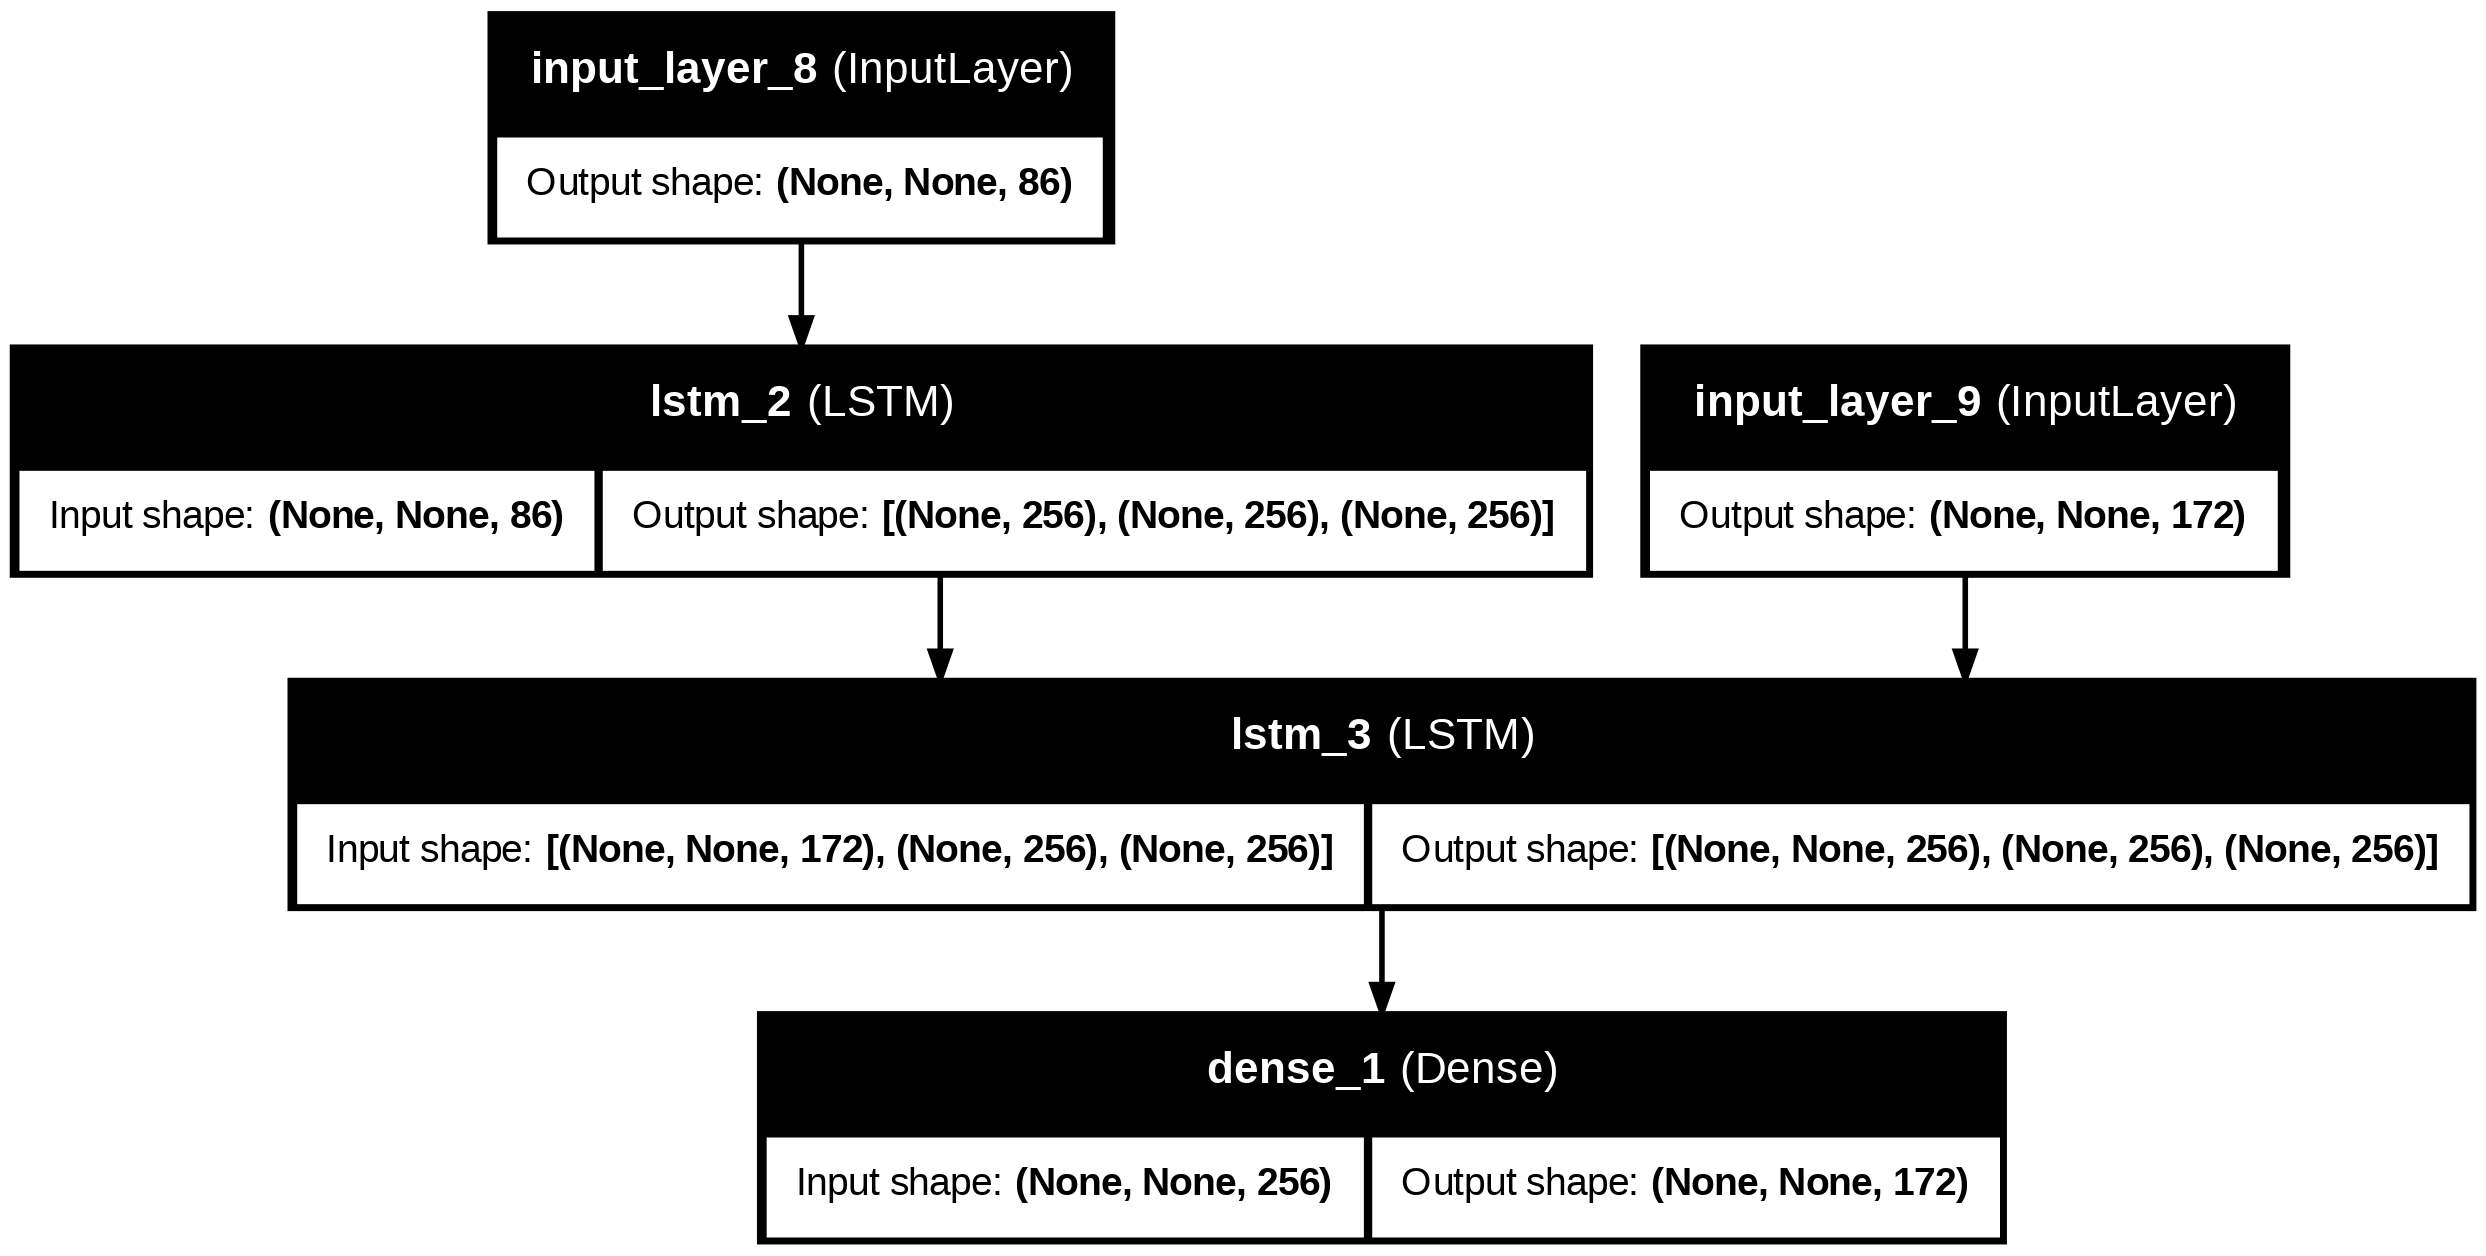

In [ ]:
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

The following code compiles the model using the `rmsprop` optimizer, `categorical_crossentropy` loss function (suitable for one-hot encoded targets), and accuracy as a performance metric. It then trains `training_model` on `encoder_input_data` and `decoder_input_data` (the input sequences for the encoder and decoder) to predict `decoder_target_data`, with training running for the specified number of epochs and batch size, and using 20% of the data for validation. Finally, the trained model is saved to a file named `training_model.keras` for future use.

In [ ]:
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history1=training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)
training_model.save('training_model.keras')

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 808ms/step - accuracy: 0.1208 - loss: 1.8158 - val_accuracy: 0.5185 - val_loss: 1.7841
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5309 - loss: 1.7513 - val_accuracy: 0.5880 - val_loss: 1.7820
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5724 - loss: 1.8900 - val_accuracy: 0.6389 - val_loss: 1.7793
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6167 - loss: 1.7650 - val_accuracy: 0.6713 - val_loss: 1.7738
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6832 - loss: 1.6870 - val_accuracy: 0.6759 - val_loss: 1.7311
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6656 - loss: 1.7521 - val_accuracy: 0.6898 - val_loss: 1.7056
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6515 - loss: 1.7878 - val_accuracy: 0.6759 - val_loss: 1.7059
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6890 - loss: 1.5768 - val_accuracy: 0.6759 - val_l

Training and validation accuracy and loss are visualized in the following graphs. We can see that:
* Training Accuracy (blue line) increases steadily, indicating that the model is learning and fitting the training data better as epochs progress.
* Validation Accuracy (orange line) improves initially but plateaus and fluctuates after a certain point. This suggests that, while the model is improving on the training data, its generalization to unseen (validation) data does not improve beyond a certain accuracy level, likely due to overfitting.
* Training Loss (blue line) decreases continuously, showing that the model is reducing its error on the training data, which is expected as the model fits the training data better with more epochs.
* Validation Loss (orange line) initially decreases but starts to increase and fluctuate after a certain point, indicating that the model is starting to overfit. This means it is learning the training data too well but fails to generalize to new data, resulting in higher error on the validation set.

In summary, the model shows signs of **overfitting**: while the training accuracy and loss continue to improve, the validation accuracy plateaus, and the validation loss increases. This suggests that the model is fitting the training data too closely, and its performance on unseen data could be improved by using techniques like early stopping, regularization, or reducing the model complexity.

The following chapters focus on improving the accuracy and quality of the model.

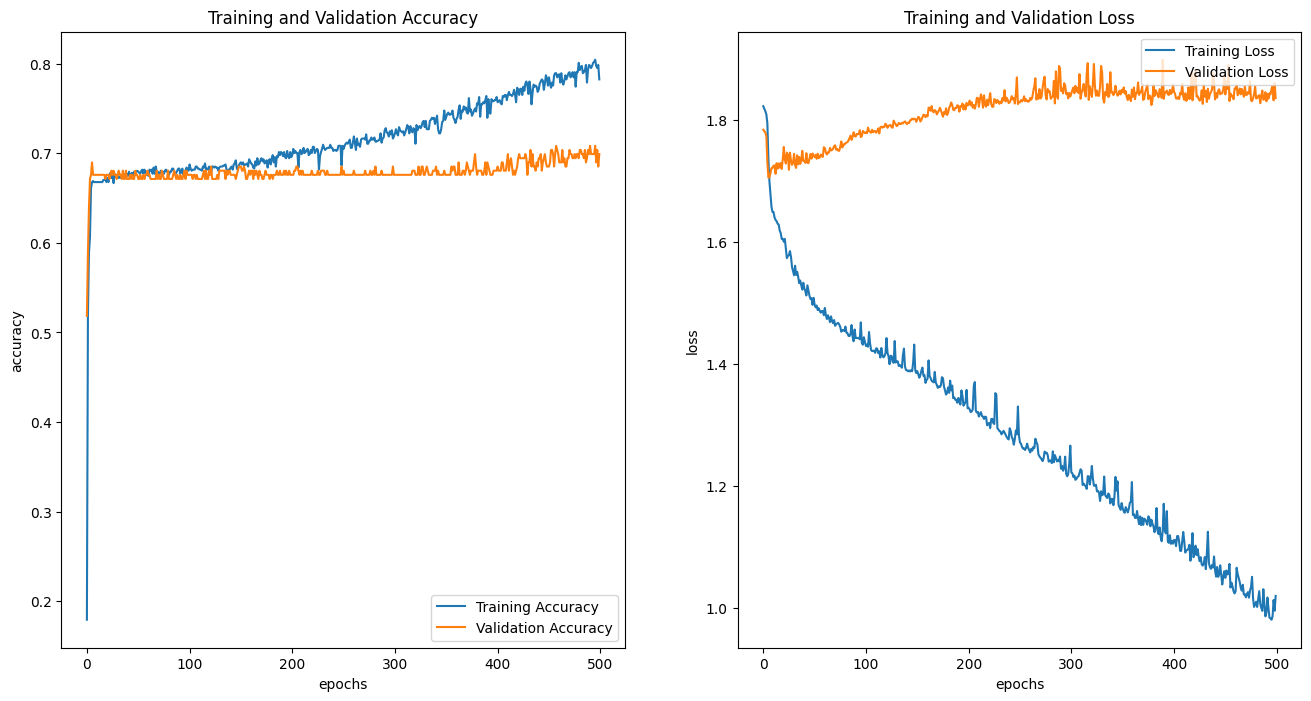

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Model Improvements

The initial procedure is largely taken from this source: https://github.com/pandeyanuradha/Chatbot-for-mental-health/blob/main/Models/Generative_based.ipynb.

As previously shown, the current model tends to overfit.

In the following sections, different techniques are applied to improve the quality and accuracy of the model.

## Data preprocessing

The newest version of `torchtext` is not compatible with the installed `torch` version. Therefore, the following index URL is specified to gather compatible packages.

In [1]:
!pip3 install torch torchtext torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install datasets evaluate

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext
import tqdm
import evaluate

In [4]:
import pandas as pd

In [6]:
dataset = pd.read_csv('mentalhealth.csv')

In [8]:
dataset.head()

,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,"Mental illness does can affect anyone, regardl..."
2,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
3,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."
4,1619387,What should I do if I know someone who appears...,We encourage those with symptoms to talk to th...


In [9]:
from sklearn.model_selection import train_test_split

In [11]:
train_data, test_data = train_test_split(dataset, test_size=0.2)

In [12]:
train_data.head()

,Question_ID,Questions,Answers
8,7760466,What is the difference between mental health p...,There are many types of mental health professi...
82,9679704,What is antisocial personality disorder?,A personality disorder is a pattern of thought...
91,4294616,How can I find help for an alcohol or drug use...,Seeking to make changes in the way you use sub...
60,1706961,What's the difference between CBT and DBT?,CBT (cognitive-behavioural therapy) and DBT (d...
18,9539480,Where can I go to find a support group?,Many people find peer support a helpful tool t...


In [13]:
en_nlp = spacy.load("en_core_web_sm")

In [14]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [50]:
sos_token = "<sos>"
eos_token = "<eos>"

def tokenize(input):
  max_length = 1_000
  lower = True

  token_list = []
  for value in input:
    tokens = [token.text for token in en_nlp.tokenizer(value)[:max_length]]
    tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    token_list.append(tokens)
  return token_list

In [46]:
t_questions = tokenize(train_data['Questions'])
t_answers = tokenize(train_data['Answers'])

train_data['t_Questions'] = t_questions
train_data['t_Answers'] = t_answers

In [48]:
t_questions = tokenize(test_data['Questions'])
t_answers = tokenize(test_data['Answers'])

test_data['t_Questions'] = t_questions
test_data['t_Answers'] = t_answers

In [47]:
train_data.head(5)

,Question_ID,Questions,Answers,t_Questions,t_Answers
8,7760466,What is the difference between mental health p...,There are many types of mental health professi...,"[<sos>, what, is, the, difference, between, me...","[<sos>, there, are, many, types, of, mental, h..."
82,9679704,What is antisocial personality disorder?,A personality disorder is a pattern of thought...,"[<sos>, what, is, antisocial, personality, dis...","[<sos>, a, personality, disorder, is, a, patte..."
91,4294616,How can I find help for an alcohol or drug use...,Seeking to make changes in the way you use sub...,"[<sos>, how, can, i, find, help, for, an, alco...","[<sos>, seeking, to, make, changes, in, the, w..."
60,1706961,What's the difference between CBT and DBT?,CBT (cognitive-behavioural therapy) and DBT (d...,"[<sos>, what, 's, the, difference, between, cb...","[<sos>, cbt, (, cognitive, -, behavioural, the..."
18,9539480,Where can I go to find a support group?,Many people find peer support a helpful tool t...,"[<sos>, where, can, i, go, to, find, a, suppor...","[<sos>, many, people, find, peer, support, a, ..."


In [49]:
test_data.head(5)

,Question_ID,Questions,Answers,t_Questions,t_Answers
90,4824231,What’s the difference between substance use an...,People tend to use the word “addiction” to mea...,"[<sos>, what, ’s, the, difference, between, su...","[<sos>, people, tend, to, use, the, word, “, a..."
41,9676742,"How can I find a doctor, psychiatrist, psychol...","To find a family doctor (general physician), v...","[<sos>, how, can, i, find, a, doctor, ,, psych...","[<sos>, to, find, a, family, doctor, (, genera..."
15,9541219,Where can I go to find therapy,Several different types of treatment and thera...,"[<sos>, where, can, i, go, to, find, therapy, ...","[<sos>, several, different, types, of, treatme..."
46,1585622,Where can I find child and youth mental health...,"To find help for a child or youth, you can: \n...","[<sos>, where, can, i, find, child, and, youth...","[<sos>, to, find, help, for, a, child, or, you..."
38,3597720,How can I reframe the situation and find more ...,How you think about something impacts your fee...,"[<sos>, how, can, i, reframe, the, situation, ...","[<sos>, how, you, think, about, something, imp..."


In [51]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

question_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["t_Questions"],
    min_freq=min_freq,
    specials=special_tokens,
)

answer_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["t_Answers"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [52]:
question_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', '?', 'i', 'what', 'can', 'do', 'a']

In [53]:
answer_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', ',', '.', 'to', 'and', 'a', 'the']

In [55]:
answer_vocab.get_stoi()['to']

6

In [56]:
len(question_vocab), len(answer_vocab)

(88, 1256)

In [57]:
assert question_vocab[unk_token] == answer_vocab[unk_token]
assert question_vocab[pad_token] == answer_vocab[pad_token]

unk_index = question_vocab[unk_token]
pad_index = question_vocab[pad_token]

In [58]:
question_vocab.set_default_index(unk_index)
answer_vocab.set_default_index(unk_index)

In [59]:
question_vocab['The']

0

In [60]:
question_vocab.get_itos()[0]

'<unk>'

In [61]:
tokens = ["i", "love", "watching", "crime", "shows"]

question_vocab.lookup_tokens(question_vocab.lookup_indices(tokens))

['i', '<unk>', '<unk>', '<unk>', '<unk>']

In [69]:
for value in train_data['t_Questions']:
  print(question_vocab.lookup_indices(value))

[2, 6, 14, 15, 21, 20, 11, 13, 78, 4, 3]
[2, 6, 14, 0, 45, 24, 4, 3]
[2, 10, 7, 5, 16, 17, 22, 34, 0, 26, 0, 38, 56, 4, 3]
[2, 6, 28, 15, 21, 20, 0, 12, 0, 4, 3]
[2, 18, 7, 5, 42, 27, 16, 9, 61, 70, 4, 3]
[2, 5, 71, 0, 32, 82, 39, 26, 46, 5, 35, 29, 14, 0, 29, 82, 19, 6, 60, 5, 8, 4, 3]
[2, 23, 5, 0, 0, 72, 63, 6, 8, 5, 55, 27, 53, 4, 3]
[2, 18, 7, 5, 42, 27, 16, 0, 35, 4, 3]
[2, 10, 7, 5, 51, 17, 76, 22, 25, 54, 4, 3]
[2, 10, 7, 5, 59, 9, 79, 4, 3]
[2, 10, 7, 5, 0, 0, 4, 3]
[2, 10, 7, 5, 59, 9, 0, 4, 3]
[2, 6, 28, 15, 21, 20, 40, 12, 0, 4, 3]
[2, 10, 7, 5, 16, 9, 61, 70, 4, 3]
[2, 6, 0, 11, 13, 57, 4, 3]
[2, 5, 30, 65, 29, 25, 68, 26, 0, 19, 18, 7, 5, 16, 17, 4, 3]
[2, 6, 31, 0, 32, 15, 0, 0, 32, 11, 36, 4, 3]
[2, 7, 0, 0, 11, 13, 57, 4, 3]
[2, 7, 0, 47, 11, 36, 0, 4, 3]
[2, 6, 14, 15, 0, 0, 0, 4, 3]
[2, 5, 0, 9, 0, 50, 5, 8, 44, 62, 37, 33, 81, 19, 6, 7, 5, 8, 4, 3]
[2, 10, 7, 5, 59, 9, 80, 4, 3]
[2, 10, 7, 5, 0, 0, 0, 4, 3]
[2, 5, 30, 9, 87, 0, 12, 0, 32, 25, 0, 52, 9, 11, 36, 19, 6

In [71]:
def numericalize(input, vocab):
    values = []
    for value in input:
        values.append(vocab.lookup_indices(value))
    return values

In [75]:
n_questions = numericalize(train_data['t_Questions'], question_vocab)
n_answers = numericalize(train_data['t_Answers'], answer_vocab)

train_data['n_Questions'] = n_questions
train_data['n_Answers'] = n_answers

In [76]:
train_data.head()

,Question_ID,Questions,Answers,t_Questions,t_Answers,n_Questions,n_Answers
8,7760466,What is the difference between mental health p...,There are many types of mental health professi...,"[<sos>, what, is, the, difference, between, me...","[<sos>, there, are, many, types, of, mental, h...","[2, 6, 14, 15, 21, 20, 11, 13, 78, 4, 3]","[2, 92, 20, 69, 710, 12, 24, 19, 198, 5, 9, 0,..."
82,9679704,What is antisocial personality disorder?,A personality disorder is a pattern of thought...,"[<sos>, what, is, antisocial, personality, dis...","[<sos>, a, personality, disorder, is, a, patte...","[2, 6, 14, 0, 45, 24, 4, 3]","[2, 8, 167, 58, 18, 8, 492, 12, 89, 4, 100, 4,..."
91,4294616,How can I find help for an alcohol or drug use...,Seeking to make changes in the way you use sub...,"[<sos>, how, can, i, find, help, for, an, alco...","[<sos>, seeking, to, make, changes, in, the, w...","[2, 10, 7, 5, 16, 17, 22, 34, 0, 26, 0, 38, 56...","[2, 1184, 6, 101, 258, 16, 9, 90, 10, 54, 271,..."
60,1706961,What's the difference between CBT and DBT?,CBT (cognitive-behavioural therapy) and DBT (d...,"[<sos>, what, 's, the, difference, between, cb...","[<sos>, cbt, (, cognitive, -, behavioural, the...","[2, 6, 28, 15, 21, 20, 0, 12, 0, 4, 3]","[2, 306, 38, 468, 21, 532, 179, 39, 7, 241, 38..."
18,9539480,Where can I go to find a support group?,Many people find peer support a helpful tool t...,"[<sos>, where, can, i, go, to, find, a, suppor...","[<sos>, many, people, find, peer, support, a, ...","[2, 18, 7, 5, 42, 27, 16, 9, 61, 70, 4, 3]","[2, 69, 25, 48, 848, 43, 8, 207, 513, 22, 17, ..."


In [77]:
n_questions = numericalize(test_data['t_Questions'], question_vocab)
n_answers = numericalize(test_data['t_Answers'], answer_vocab)

test_data['n_Questions'] = n_questions
test_data['n_Answers'] = n_answers

In [78]:
test_data.head()

,Question_ID,Questions,Answers,t_Questions,t_Answers,n_Questions,n_Answers
90,4824231,What’s the difference between substance use an...,People tend to use the word “addiction” to mea...,"[<sos>, what, ’s, the, difference, between, su...","[<sos>, people, tend, to, use, the, word, “, a...","[2, 6, 33, 15, 21, 20, 0, 38, 12, 0, 4, 3]","[2, 25, 1211, 6, 54, 9, 0, 401, 0, 402, 6, 384..."
41,9676742,"How can I find a doctor, psychiatrist, psychol...","To find a family doctor (general physician), v...","[<sos>, how, can, i, find, a, doctor, ,, psych...","[<sos>, to, find, a, family, doctor, (, genera...","[2, 10, 7, 5, 16, 9, 0, 39, 79, 39, 80, 39, 26...","[2, 6, 48, 8, 74, 65, 38, 560, 0, 39, 4, 133, ..."
15,9541219,Where can I go to find therapy,Several different types of treatment and thera...,"[<sos>, where, can, i, go, to, find, therapy, ...","[<sos>, several, different, types, of, treatme...","[2, 18, 7, 5, 42, 27, 16, 0, 3]","[2, 878, 67, 710, 12, 132, 7, 179, 22, 17, 32,..."
46,1585622,Where can I find child and youth mental health...,"To find help for a child or youth, you can: \n...","[<sos>, where, can, i, find, child, and, youth...","[<sos>, to, find, help, for, a, child, or, you...","[2, 18, 7, 5, 16, 68, 12, 0, 11, 13, 0, 4, 3]","[2, 6, 48, 32, 14, 8, 237, 11, 330, 4, 10, 17,..."
38,3597720,How can I reframe the situation and find more ...,How you think about something impacts your fee...,"[<sos>, how, can, i, reframe, the, situation, ...","[<sos>, how, you, think, about, something, imp...","[2, 10, 7, 5, 0, 15, 0, 12, 16, 74, 0, 0, 4, 3]","[2, 78, 10, 155, 34, 229, 807, 15, 100, 7, 15,..."


In [5]:
import pandas as pd

data = {'product': ['Tablet', 'Printer', 'Laptop', 'Monitor'],
        'price': [250, 100, 1200, 300]
        }

df = pd.DataFrame(data)

df['product'].values


array(['Tablet', 'Printer', 'Laptop', 'Monitor'], dtype=object)

In [1]:
train_data['n_Questions'].values

NameError: name 'train_data' is not defined

In [101]:
batch = train_data

batch_en_ids = [example["n_Questions"].values for example in batch]
batch_de_ids = [example["n_Answers"].values for example in batch]
batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
batch = {
    "n_Questions": batch_en_ids,
    "n_Answers": batch_de_ids,
}

TypeError: string indices must be integers

In [80]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["n_Questions"] for example in batch]
        batch_de_ids = [example["n_Answers"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "n_Questions": batch_en_ids,
            "n_Answers": batch_de_ids,
        }
        return batch

    return collate_fn

In [81]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [86]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## Encoder - Decoder Model

In [87]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

In [88]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell

In [89]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        # input = [batch size]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [91]:
input_dim = len(question_vocab)
output_dim = len(answer_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [92]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(88, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1256, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=1256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [94]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 8,344,808 trainable parameters


In [95]:
optimizer = optim.Adam(model.parameters())

In [96]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

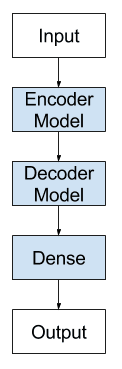

In [97]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [98]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [99]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        test_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]


KeyError: 1

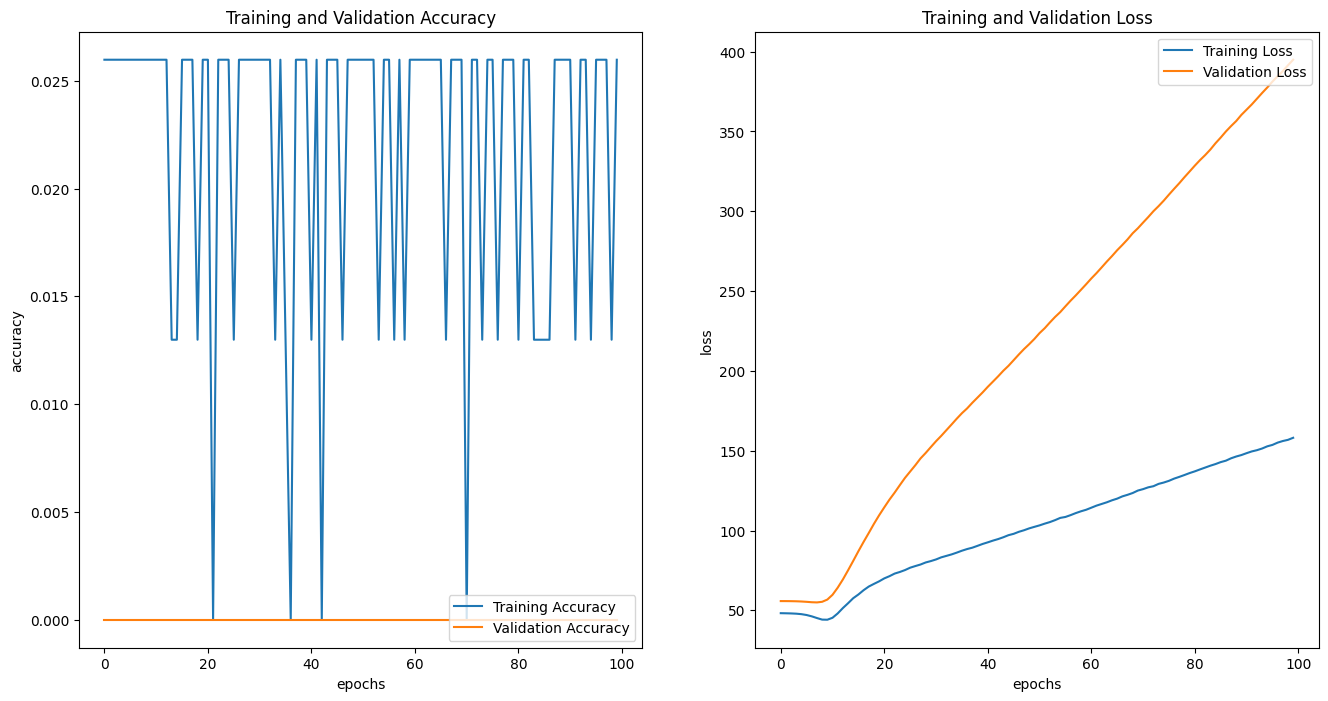

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Demo

## Predictions

In [ ]:
from keras.models import load_model
training_model = load_model('training_model.keras')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

In [ ]:
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [ ]:
training_model = load_model('training_model.keras')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)

    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))

    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.

    #A variable to store our response word by word
    decoded_sentence = ''

    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

          #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token

          #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

          #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.

          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

In [ ]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")

  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. AMA!\n")

    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)

  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")

  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix

  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response

  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False

chatbot = ChatBot()

In [ ]:
chatbot.start_chat()

Hi, I'm a chatbot trained on random dialogs. AMA!
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17

# Falcon

In [ ]:
!pip install trl transformers accelerate peft -Uqqq
!pip install datasets bitsandbytes einops wandb -Uqqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires f

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import pandas as pd

data = pd.read_csv('mentalhealth.csv')

In [ ]:
data.shape

(97, 3)

In [ ]:
model_name = "ybelkada/falcon-7b-sharded-bf16" # sharded falcon-7b model

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,            # load model in 4-bit precision
    bnb_4bit_quant_type="nf4",    # pre-trained model should be quantized in 4-bit NF format
    bnb_4bit_use_double_quant=True, # Using double quantization as mentioned in QLoRA paper
    bnb_4bit_compute_dtype=torch.bfloat16, # During computation, pre-trained model should be loaded in BF16 format
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Use bitsandbytes config
    device_map="auto",  # Specifying device_map="auto" so that HF Accelerate will determine which GPU to put each layer of the model on
    trust_remote_code=True, # Set trust_remote_code=True to use falcon-7b model with custom code
)


config.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/921M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) # Set trust_remote_code=True
tokenizer.pad_token = tokenizer.eos_token # Setting pad_token same as eos_token

tokenizer_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [ ]:
model = prepare_model_for_kbit_training(model)

lora_alpha = 32 # scaling factor for the weight matrices
lora_dropout = 0.05 # dropout probability of the LoRA layers
lora_rank = 32 # dimension of the low-rank matrices

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_rank,
    bias="none",  # setting to 'none' for only training weight params instead of biases
    task_type="CAUSAL_LM",
    target_modules=[         # Setting names of modules in falcon-7b model that we want to apply LoRA to
        "query_key_value",
        "dense",
        "dense_h_to_4h",
        "dense_4h_to_h",
    ]
)

peft_model = get_peft_model(model, peft_config)

In [ ]:
output_dir = "./falcon-7b-sharded-bf16-finetuned-mental-health-conversational"
per_device_train_batch_size = 16 # reduce batch size by 2x if out-of-memory error
gradient_accumulation_steps = 4  # increase gradient accumulation steps by 2x if batch size is reduced
optim = "paged_adamw_32bit" # activates the paging for better memory management
save_strategy="steps" # checkpoint save strategy to adopt during training
save_steps = 10 # number of updates steps before two checkpoint saves
logging_steps = 10  # number of update steps between two logs if logging_strategy="steps"
learning_rate = 2e-4  # learning rate for AdamW optimizer
max_grad_norm = 0.3 # maximum gradient norm (for gradient clipping)
max_steps = 320        # training will happen for 320 steps
warmup_ratio = 0.03 # number of steps used for a linear warmup from 0 to learning_rate
lr_scheduler_type = "cosine"  # learning rate scheduler

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    bf16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    push_to_hub=True,
)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Question_ID  97 non-null     int64 
 1   Questions    97 non-null     object
 2   Answers      97 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


In [ ]:
data

Dataset({
    features: ['Question_ID', 'Questions', 'Answers'],
    num_rows: 97
})

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer = SFTTrainer(
    model=peft_model,
    train_dataset=data,
    dataset_text_field='Answers',
    peft_config=peft_config,
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
)


Map:   0%|          | 0/97 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
# upcasting the layer norms in torch.bfloat16 for more stable training
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.bfloat16)


In [ ]:
# authenticate WandB for logging metrics
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [ ]:
peft_model.config.use_cache = False
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.44 GiB. GPU 0 has a total capacity of 14.75 GiB of which 2.40 GiB is free. Process 2502 has 12.35 GiB memory in use. Of the allocated memory 12.11 GiB is allocated by PyTorch, and 115.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

263